# Mini Project : Deep Learning (Machine Learning GDGoC Universitas Sriwijaya)

- Muhammad Aditya Bayhaqie
- Nabila Nurhusna Yap

Objective :

> Build a deep learning model to solve a problem either in image classification, text classification, or sequence prediction.

## CNN Model

### Library Preparation

In [1]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import shutil

### Data Wrangling

#### Data Assessment

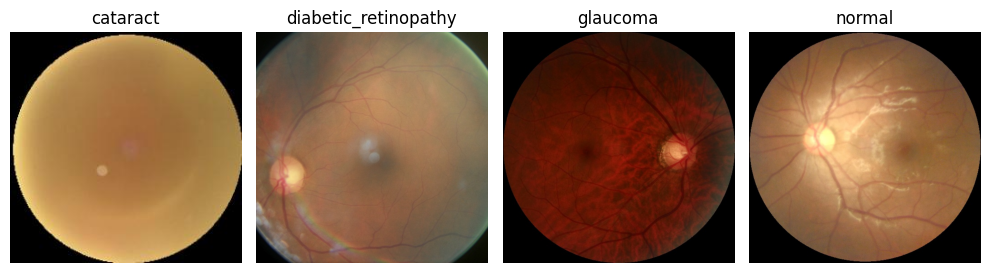

In [2]:
def display_images_by_label(data_dir):
    labels = os.listdir(data_dir)
    labels.sort() # Sort labels for consistent display

    fig, axes = plt.subplots(1, 4, figsize=(10, 10))
    axes = axes.ravel()

    # Limit to the number of subplots available
    num_subplots = len(axes)
    for i, label in enumerate(labels[:num_subplots]):
        label_path = os.path.join(data_dir, label)
        if os.path.isdir(label_path):
            image_files = [f for f in os.listdir(label_path) if f.endswith(('jpg', 'jpeg', 'png'))]
            if image_files:
                # Select a random image from the label directory
                random_image_file = random.choice(image_files)
                img_path = os.path.join(label_path, random_image_file)
                img = mpimg.imread(img_path)

                axes[i].imshow(img)
                axes[i].set_title(label)
                axes[i].axis('off') # Hide axes

    # Hide any unused subplots if there are less than the number of subplots
    for j in range(len(labels), num_subplots):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Assuming the unzipped data is in a directory named 'dataset'
# Adjust the path according to where your unzipped data is located
data_directory = '/kaggle/input/eye-diseases-classification/dataset'
display_images_by_label(data_directory)

#### Data Engineering

In [3]:
# Define the original data directory and the new train/val directories
data_directory = '/kaggle/input/eye-diseases-classification/dataset'
train_dir = '/kaggle/working/train'
val_dir = '/kaggle/working/val'

# Create the train and validation directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Get the list of labels (subdirectories)
labels = os.listdir(data_directory)

for label in labels:
    label_path = os.path.join(data_directory, label)
    if os.path.isdir(label_path):
        # Create subdirectories for the label in train and val
        train_label_dir = os.path.join(train_dir, label)
        val_label_dir = os.path.join(val_dir, label)
        os.makedirs(train_label_dir, exist_ok=True)
        os.makedirs(val_label_dir, exist_ok=True)

        # Get the list of image files in the current label directory
        image_files = [f for f in os.listdir(label_path) if f.endswith(('jpg', 'jpeg', 'png'))]
        random.shuffle(image_files) # Shuffle the images

        # Calculate the split point (90% for training)
        split_point = int(len(image_files) * 0.9)

        # Split the images into training and validation sets
        train_files = image_files[:split_point]
        val_files = image_files[split_point:]

        # Copy the files to the respective train and val directories
        for filename in train_files:
            src_path = os.path.join(label_path, filename)
            dest_path = os.path.join(train_label_dir, filename)
            shutil.copy(src_path, dest_path)

        for filename in val_files:
            src_path = os.path.join(label_path, filename)
            dest_path = os.path.join(val_label_dir, filename)
            shutil.copy(src_path, dest_path)

print("Data split into train and validation directories (9:1 ratio) successful.")
print(f"Train data saved in: {train_dir}")
print(f"Validation data saved in: {val_dir}")

Data split into train and validation directories (9:1 ratio) successful.
Train data saved in: /kaggle/working/train
Validation data saved in: /kaggle/working/val


In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
    ]),
}

data_dir = '/kaggle/working/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x.lower()])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Model Development

### Model Evaluation

## Pre-Build Model

### Library Preparation

### Data Wrangling

#### Data Collection

#### Data Assessment

#### Data Engineering

### Model Development

### Model Evaluation